# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
import numpy as np
import cv2

In [3]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = y_train.shape[0]

# TODO: Number of testing examples.
n_test = y_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:3]

# TODO: How many unique classes/labels there are in the dataset.
u, indices = np.unique(y_train, return_index=True)
n_classes = len(u)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

In [5]:
import csv

# parse the signal names list and store for later
with open('signnames.csv') as csvfile:
    sign_names_csv = csv.reader(csvfile, delimiter=',')
    sign_names={}
    for row in sign_names_csv:
        sign_names[row[0]] = row[1]
 

In [6]:
# find counts for each class/sign type
u, indices, u_counts = np.unique(y_train, return_index=True, return_counts=True)

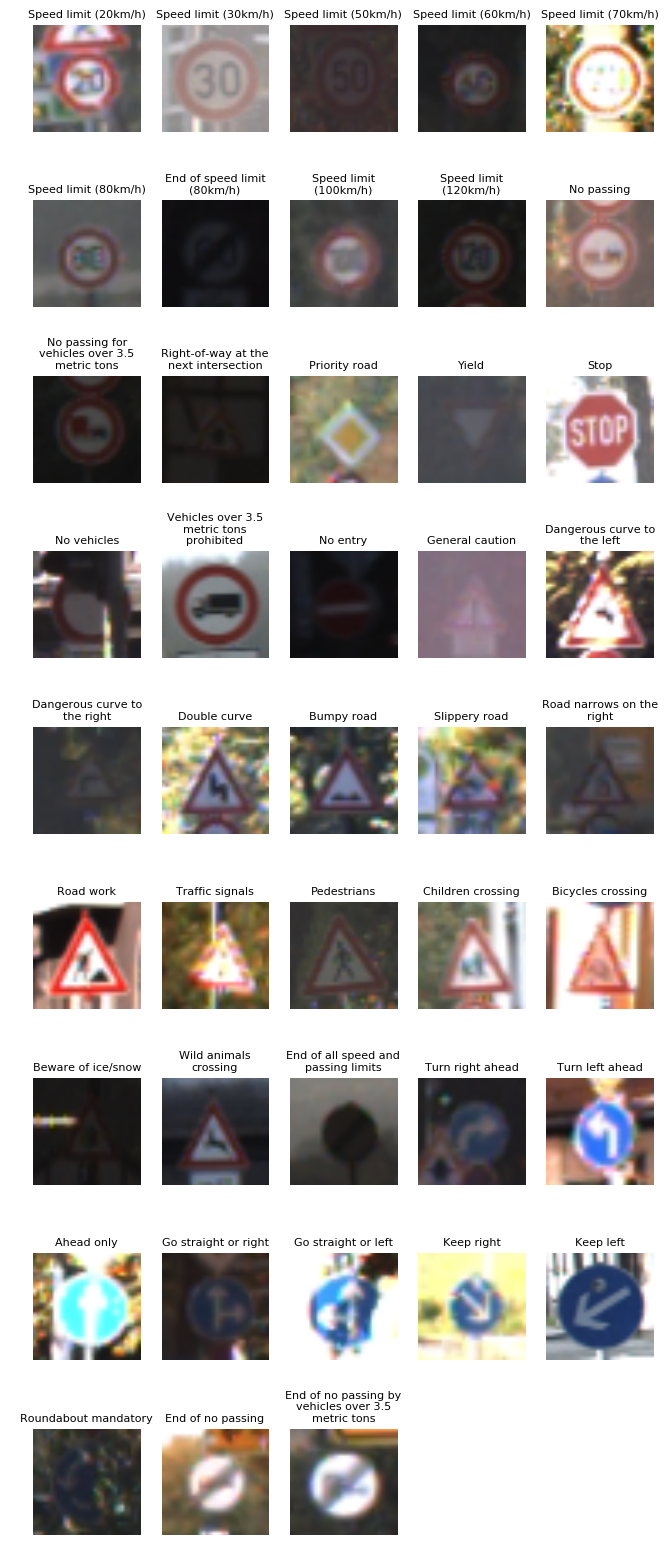

In [7]:
from textwrap import wrap

# plot the first occurance of each sign and show its name

cols = 5
rows = len(indices) // cols
plt.figure(figsize=(8,20))
for i,val in enumerate(indices):
    plt.subplot(rows+1, cols, i+1)
    plt.imshow(X_train[val])
    plt.title("\n".join(wrap(sign_names[str(y_train[val])],20)),fontsize=8)
    plt.axis('off')

plt.show()

210

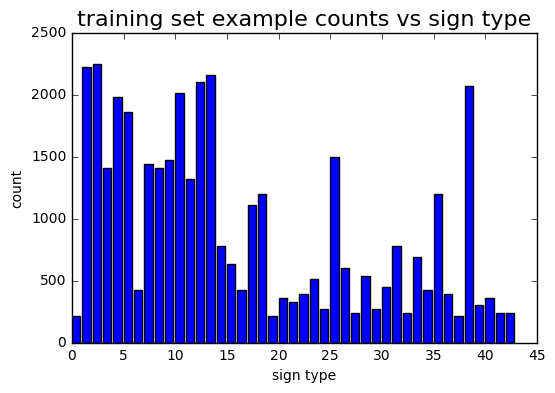

In [8]:
# plot counts for each class

plt.bar(u,u_counts)
plt.xlabel('sign type')
plt.ylabel('count')
plt.title('training set example counts vs sign type', fontsize=16)
min(u_counts)

### Create additional synthetic data:
<a id='create_data'></a>

In [9]:
import random

# helper functions for creating additional data based on randomly jittered sample of the original data

def rot_and_scale(img, theta, scale):
    rows,cols,_ = img.shape

    M = cv2.getRotationMatrix2D((cols/2,rows/2),theta,scale)
    return cv2.warpAffine(img,M,(cols,rows))

def translate(img, tx, ty):
    rows,cols,_ = img.shape

    M = np.float32([[1,0,tx],[0,1,ty]])
    return cv2.warpAffine(img,M,(cols,rows))

# randomly perturb the source image by translating by [-2,2] pixels, scaling by [.9,1.1] and rotating [-15,+15] degrees
def jitter(img):
    tx = random.randint(-2,2)
    ty = random.randint(-2,2)
    scale = random.uniform(.9, 1.1)
    theta = random.uniform(-15,15)
    
    return translate(rot_and_scale(img, theta, scale),tx,ty)
    
    

In [13]:
# create jittered data

sample_mult = 5
X_jittered = np.zeros( (len(X_train)*sample_mult,32,32,3), dtype='uint8' )
for i in range(len(X_train)):
    for j in range(sample_mult):
        X_jittered[i*sample_mult+j] = jitter(X_train[i])


In [14]:
# add jittered data to the original data set

X_train = np.concatenate((X_train, X_jittered))
y_train = np.concatenate((y_train, np.repeat(y_train, sample_mult)))

### Create a validation set:
<a id='create_valid'></a>

In [15]:
# split off 20% of the training data and call it a validation set

from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

n_train = y_train.shape[0]
n_validation = y_validation.shape[0]

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)

Number of training examples = 188203
Number of validation examples = 47051


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [16]:
# helper function for converting the training data into grayscale

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

X_train_gr = np.empty((n_train, 32, 32, 1))
X_validation_gr = np.empty((n_validation, 32, 32, 1))
X_test_gr = np.empty((n_test, 32, 32, 1))

In [17]:
# convert each set to grayscale

for i in range(n_train):
    X_train_gr[i,:,:,0] = grayscale(X_train[i])
 
for i in range(n_validation):
    X_validation_gr[i,:,:,0] = grayscale(X_validation[i])
    
for i in range(n_test):
    X_test_gr[i,:,:,0] = grayscale(X_test[i])

In [18]:
# replace color data with grayscale data

X_train = X_train_gr
X_validation = X_validation_gr
X_test = X_test_gr

In [19]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

from sklearn.utils import shuffle

# shuffle the data
X_train, y_train = shuffle(X_train, y_train)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

I have tried training both on color images as well as grayscale images. While this does not make much difference in terms of training accuracy, converting images to grayscale results in a slightly better training accuracy.

When the data is initially loaded from the file it is sorted by image type which groups all images belonging to a sign type together. Training on such a data set may lead to the learning algorithm converging to a local minimum and consequently to a model that is not able generalize well. I used the shuffle function from the sklearn library to randomize the training data prior to training.

In [ ]:
### Generate data additional data (OPTIONAL!)
### split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

## See [above](#create_data) for additional data generation
## See [above](#create_valid) for validation set

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

I used train_test_split() function from sklearn library to split off 20% of the training data set to use a validation data set. I used the same split (20% for validation, 80% for training) for both the original and synthetically generated data. The downloaded data set contained a test data set (test.p) which I used only once I finished training the model (see the last cell in this notebook).


**Optional:**
At first I trained the model using only the supplied data but found that while it did achieve fairly good training accuracy it did not do well on the images I downloaded off the internet. I  decided that the likely cause was overfitting which caused the model not to generalize well to examples it hasn't see during training. One way to deal with overfitting is to train on more data. Indeed, after training on the larger data set the the model performed much better. Another option would have been to add regularization, I did not explore that option since adding more data seemed to work well enough.

I generated additional data by  randomly "jittering" images from the original data set as described in the paper linked above. I randomly perturbed the source image by translating it by [-2,2] pixels, scaling by [.9,1.1] and rotating [-15,+15] degrees 5 times each. The new data set was then merged with the original data set and shuffled.

In [20]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf

tf.reset_default_graph()

EPOCHS = 20
BATCH_SIZE = 128

In [21]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.12
    
    # Modified LeNet network
    
    # for grayscale images
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Adding a brached out output of stage 1 to the output of stage 2
    # input from stage 2 = 10x10x16, input from stage 1 = 14x14x6
    fc0 = tf.concat(1, [flatten(conv2), flatten(conv1)])

    # Layer 3: Fully Connected. Input = 1576. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1576, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [22]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

I eventually settled on a modified version of the LeNet architecture. First, it was modified to accept grayscale images with depth of 1 and its output was expanded to classy 43 types of inputs instead of the original 10. This version of the network worked remarkably well, achieving around 95% accuracy on the original data set.

Later I added a branched connection of the convolutional layer 1 after pooling to the fully connected output layer (layer 5) as described in the paper linked above. This further improved training accuracy to 96-97%

The resulting architecture looks as follows:

* Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
* RELU Activation.
* Pooling. Input = 28x28x6. Output = 14x14x6.
* Layer 2: Convolutional. Output = 10x10x16.  
* RELU Activation.
* Pooling. Input = 10x10x16. Output = 5x5x16.
* Adding a branched output of stage 1 to the output of stage 2, input from stage 2 = 10x10x16, input from stage 1 = 14x14x6
* Layer 3: Fully Connected. Input = 1576. Output = 120.    
* RELU Activation.
* Layer 4: Fully Connected. Input = 120. Output = 84.
* RELU Activation.
* Layer 5: Fully Connected. Input = 84. Output = 43.

In [23]:
### Train your model here.
### Feel free to use as many code cells as needed.

# add adaptive rate
adaptive_rate = tf.placeholder(tf.float32, shape=[])

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = adaptive_rate)
training_operation = optimizer.minimize(loss_operation)

In [24]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [25]:
rate = 0.001

va = np.array([])

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        #if i == 10:
        #    rate = rate / 2.
        #if i == 20:
        #    rate = rate / 2.
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, adaptive_rate: rate})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {}: Validation Accuracy = {:.3f}".format(i+1, validation_accuracy))
        va = np.append(va, validation_accuracy)  
    
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, 'lenet')
    print("Model saved")

Training...

EPOCH 1: Validation Accuracy = 0.140
EPOCH 2: Validation Accuracy = 0.639
EPOCH 3: Validation Accuracy = 0.825
EPOCH 4: Validation Accuracy = 0.888
EPOCH 5: Validation Accuracy = 0.896
EPOCH 6: Validation Accuracy = 0.926
EPOCH 7: Validation Accuracy = 0.936
EPOCH 8: Validation Accuracy = 0.930
EPOCH 9: Validation Accuracy = 0.945
EPOCH 10: Validation Accuracy = 0.946
EPOCH 11: Validation Accuracy = 0.952
EPOCH 12: Validation Accuracy = 0.946
EPOCH 13: Validation Accuracy = 0.958
EPOCH 14: Validation Accuracy = 0.956
EPOCH 15: Validation Accuracy = 0.963
EPOCH 16: Validation Accuracy = 0.955
EPOCH 17: Validation Accuracy = 0.966
EPOCH 18: Validation Accuracy = 0.967
EPOCH 19: Validation Accuracy = 0.968
EPOCH 20: Validation Accuracy = 0.966
Model saved


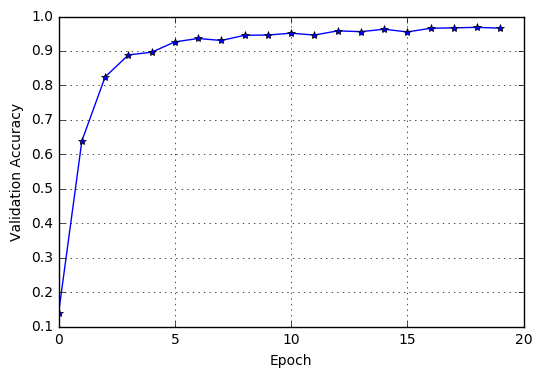

In [26]:
plt.plot(va,'-*')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.grid()

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I played around with a number of parameters when training the model. Here is a list of "knobs" I tweaked as I evaluated training performance:

* color vs grayscale input images
* original dataset vs synthetically expanded dataset
* number of additional synthetic examples
* number of epochs
* learning rate
* constant vs dynamically adjusted training rate (as a function of training accuracy)
* batch size 
* lenet vs modified lenet architecture

The best performance was achieved with the following set of parameters:
* grayscale data set
* synthetically expanded data set (5x extra examples)
* 20 epochs
* learning rate of 0.001
* constant learning rate
* batch size of 256
* modified lenet architecture

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I started with the slightly modified version of lenet which ended up working remarkly well. From there it was a matter of exploring the hyperparameter space as described above as well as expanding the original lenet architecture based on the traffic sign implementation described in the Sermanet and LeCun's paper linked above

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

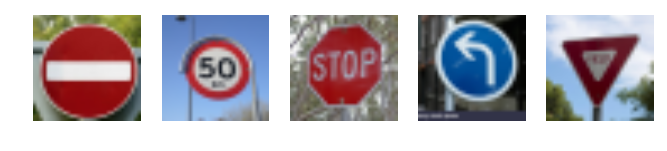

In [27]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

def resize_and_crop(image):
    if image.shape[1] < image.shape[0]:
        r = 32.0 / image.shape[1]
        dim = (32, int(image.shape[0] * r))
    else:
        r = 32.0 / image.shape[0]
        dim = (int(image.shape[1] * r), 32)
 
    # perform the actual resizing of the image and show it
    re_im = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    
    if re_im.shape[0] > 32:
        offset = (re_im.shape[0] - 32) // 2
        return re_im[offset:32+offset,0:32]
    else:
        offset = (re_im.shape[1] - 32) // 2
        return re_im[0:32, offset:32+offset]

# resize and crop raw images to 32x32 size
noentry = resize_and_crop(cv2.imread('noentry.jpg', cv2.IMREAD_COLOR))
speedlimit50 = resize_and_crop(cv2.imread('speedlimit50.jpg', cv2.IMREAD_COLOR))
stop = resize_and_crop(cv2.imread('stop.jpg', cv2.IMREAD_COLOR))
turnleftahead = resize_and_crop(cv2.imread('turnleftahead.jpg', cv2.IMREAD_COLOR))
yieldsign = resize_and_crop(cv2.imread('yield.jpg', cv2.IMREAD_COLOR))

img_list=[noentry, speedlimit50, stop, turnleftahead, yieldsign]

#plt.imshow(cv2.cvtColor(noentry, cv2.COLOR_BGR2RGB))
plt.figure(figsize=(8,2))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(cv2.cvtColor(img_list[i], cv2.COLOR_BGR2RGB))
    plt.axis('off')

In [28]:
X_verify = np.array(img_list)
y_verify = np.array([17, 2, 14, 34, 13])

In [29]:
# convert to grayscale
X_verify_gr = np.empty((5, 32, 32, 1))
for i in range(5):
    X_verify_gr[i,:,:,0] = grayscale(X_verify[i])

In [30]:
X_verify = X_verify_gr

In [31]:
import os
cwd = os.getcwd()
print(cwd)

/home/carnd/CarND-Traffic-Sign-Classifier-Project


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

Please see the plots above. I downloaded a few images off the internet by searching google with a random sampling of sign names from the original data set. Each image was selected to be a photograph of a real scene rather than a computer generated artifact. The images I selected look reasonably good and I would expect that a well trained model should have no trouble identifying them. Each source image was resized and cropped to 32x32 pixel size the network expects.

In [32]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    tf.train.Saver().restore(sess, '/home/carnd/CarND-Traffic-Sign-Classifier-Project/lenet')
    validation_accuracy = evaluate(X_verify, y_verify)

    print("Validation Accuracy = {:.3f}".format(validation_accuracy))


Validation Accuracy = 0.800


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

The model identifies 4/5 signs correctly (80% accuracy). The sign it had trouble with is the "turn left ahead" sign shown below. I suspect that the extra stock photo text (the word "alamy") might have been responsible for tripping the model up. My conjecture is that the text turns into blurred lines or streaks in the downsampled version of the image (32x32 pixel input to the model pictured above) which may be misidentified as low level features by early convolutional layers of the model.

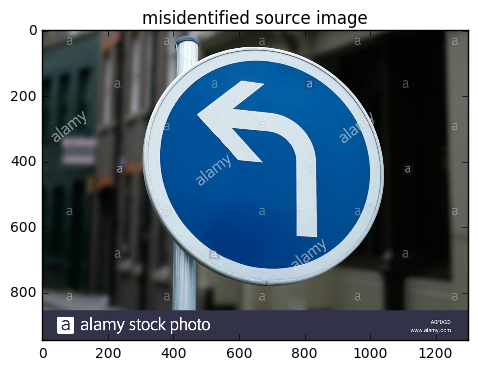

In [36]:
plt.imshow(cv2.cvtColor(cv2.imread('turnleftahead.jpg', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB))
plt.title("misidentified source image")

In [33]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
top_predictions = tf.nn.top_k(tf.nn.softmax(logits), k=3)

with tf.Session() as sess:
    tf.train.Saver().restore(sess, '/home/carnd/CarND-Traffic-Sign-Classifier-Project/lenet')
    prob, ind = sess.run(top_predictions, feed_dict={x: X_verify, y: y_verify})
    
print("{:5} | {:20} | {:20} | {:20} | {:20}".format("N ex","Target","1st choice","2nd choice","3rd choice"))
print("--------------------------------------------------------------------------------------------------")
for i in range(5):
    print("{:5} | {:20} | {:20} | {:20} | {:20}".format(u_counts[y_verify[i]], sign_names[str(y_verify[i])], sign_names[str(ind[i,0])], sign_names[str(ind[i,1])],sign_names[str(ind[i,2])]))      

print("\n\n")
print("{:5} | {:20} | {:20}".format("", "Target", "1st choice prob %"))
print("------------------------------------------------------------------")
for i in range(5):
    print("{:5} | {:20} | {:20.2}".format("", sign_names[str(y_verify[i])], prob[i,0]))

N ex  | Target               | 1st choice           | 2nd choice           | 3rd choice          
--------------------------------------------------------------------------------------------------
 1110 | No entry             | No entry             | Speed limit (20km/h) | Speed limit (30km/h)
 2250 | Speed limit (50km/h) | Speed limit (50km/h) | Speed limit (80km/h) | Speed limit (30km/h)
  780 | Stop                 | Stop                 | Turn right ahead     | No entry            
  420 | Turn left ahead      | End of no passing by vehicles over 3.5 metric tons | Keep right           | No passing for vehicles over 3.5 metric tons
 2160 | Yield                | Yield                | Speed limit (20km/h) | Speed limit (30km/h)



      | Target               | 1st choice prob %   
------------------------------------------------------------------
      | No entry             |                  1.0
      | Speed limit (50km/h) |                 0.73
      | Stop                 |   

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

The model appears to be pretty certain with most of the signs (including the one it gets wrong). It is interesting that it is less certain (although correct) about the "speed limit 50" sign and assigns significant probabilities to other similar looking signs such as "speed limit 80" and "speed limit 30" which seems very reasonable since the signs do share a large degree of similarity.

In [37]:
with tf.Session() as sess:
    tf.train.Saver().restore(sess, '/home/carnd/CarND-Traffic-Sign-Classifier-Project/lenet')
    accuracy = evaluate(X_test, y_test)

    print("Test set accuracy = {:.3f}".format(accuracy))

Test set accuracy = 0.947


Test set accuracy is pretty good at around 95% which is just a bit lower than the validation set accuracy of 97%

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.